In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors 
# %matplotlib notebook

import ipysh

%aimport models.base

import Hunch_utils  as Htls
import Hunch_lsplot as Hplt
import Hunch_tSNEplot as Hsne

%aimport Dataset_QSH
%aimport models.AEFIT5
%aimport models.Compose
%aimport models.GAN3

import livelossplot.keras
class PlotLossesCallback(livelossplot.keras.PlotLossesCallback):
    def on_train_batch_begin(self, a, b): pass
    def on_train_batch_end(self, a, b): pass
    def on_test_begin(self, a): pass
    def on_test_end(self, a): pass
    def on_test_batch_begin(self, a, b): pass
    def on_test_batch_end(self, a, b): pass

    
class PlotRelevanceCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        fig.set_size_inches(13, 3)
        w = self.model.layers[0].weights
        ax1.bar(range(0,4), w[0][0:4])
        labels = ['Ip','NS','Vt','F']
        plt.sca(ax1)
        plt.xticks(range(0,4), labels, fontsize=10)
        ax2.bar(range(7,17), w[0][4:14])
        plt.sca(ax2)
        plt.xticks(range(7,17), fontsize=10)        
        ax3.bar(range(7,17), w[0][14:24])
        plt.sca(ax3)
        plt.xticks(range(7,17), fontsize=10)       


# ipysh.Bootstrap_support.debug()

Hunch models imported
reload set for module  Hunch_utils
reload set for module  Dummy_g1data
reload set for module  Hunch_lsplot
reload set for module  Hunch_tSNEplot


Using TensorFlow backend.


# TEST QSH


In [2]:
qsh = Dataset_QSH.Dataset_QSH()
import os
#file = ipysh.abs_builddir+'/te_db_r15_clean_shuffle.npy'
file = ipysh.abs_builddir+'/te_db_r15u_shuffle.npy'
try: qsh.load(file)
except: raise FileNotFoundError

# qsh.shuffle()
qsh.dim = None
qsh.set_null(np.nan)
qsh.set_normal_positive(['prel','te','tbordo','tcentro', 'Ip','NS','VT','F','absBr_rm','argBr_rm','absBt_rm','argBt_rm']) 
print("QSH rebalanced 15 points size: ", len(qsh))




QSH rebalanced 15 points size:  47567


In [3]:
def _map(xy,p,Br):
    pBr = tf.concat([p,Br], axis=0)
    return pBr,xy

ds = qsh.tf_tuple_compose(['prel~te:15','Ip~NS~VT~F','absBr_rm~argBr_rm~absBt_rm~argBt_rm']).map(lambda x,y,br: _map(x,y,br) )
[x for x in ds.shuffle(100).batch(1).take(1)][0]

(<tf.Tensor: id=57, shape=(1, 44), dtype=float32, numpy=
 array([[0.91829884, 0.89892954, 0.8760379 , 0.67403305, 0.43288103,
         0.01467069, 0.04710959, 0.02969822, 0.04187761, 0.01623156,
         0.01062462, 0.01441337, 0.0343423 , 0.01841393, 0.09725146,
         0.87176275, 0.22261667, 0.95606786, 0.1204173 , 0.6052855 ,
         0.12355117, 0.339744  , 0.8911285 , 0.0262408 , 0.8439119 ,
         0.0354065 , 0.03797842, 0.04818082, 0.02697818, 0.0428591 ,
         0.04367265, 0.02869688, 0.0205324 , 0.02595562, 0.3095279 ,
         0.9730016 , 0.45651007, 0.14552441, 0.38951626, 0.88127714,
         0.25620463, 0.73842233, 0.07768814, 0.44820866]], dtype=float32)>,
 <tf.Tensor: id=58, shape=(1, 30), dtype=float32, numpy=
 array([[0.06187461, 0.10253274,        nan, 0.20810291, 0.27413067,
         0.34849414,        nan, 0.51404023, 0.5986438 , 0.6795865 ,
         0.7539499 , 0.81997764, 0.87707865, 0.9255478 , 0.96620595,
         0.3636757 , 0.36477837,        nan, 0.4108

In [4]:
vae = models.AEFIT5.AEFIT5(latent_dim=6, feature_dim=30, dprate=0.1, beta=0., scale=2, geometry=[20,20,10,10])
vae.compile( vae.optimizer, tf.losses.mse )

AEFIT5 ready:


In [15]:
dds = ds.map(lambda p,xy: (xy,xy))
vae_history = vae.fit( dds.skip(5000).batch(100, drop_remainder=True), validation_data=dds.take(5000).batch(100), epochs=50, shuffle=False)

Epoch 1/50
    177/Unknown - 13s 71ms/step - loss: 7.1568e-04

KeyboardInterrupt: 

In [5]:
##### vae.save('step12_vae_ls_tesi') 
vae.load('step12_vae_ls_tesi')

# vae.inference_net.get_config()
# tf.saved_model.save(vae.inference_net, '/tmp/thesis/vae/12_7/inference_net')
# cacca = tf.saved_model.load('/tmp/thesis/vae/12_7/inference_net')


In [6]:
vae1 = models.AEFIT5.AEFIT5(latent_dim=3, feature_dim=44, dprate=0.1, scale=2, geometry=[20,20,10,10])
vae1.generative_net.trainable = False
gen = vae1.inference_net

AEFIT5 ready:


In [7]:
Dds = ds.map(lambda p,xy: (p, tf.reshape(vae.encode(tf.reshape(xy,[1,-1]),training=False)[0],[-1])) )
[x for x in Dds.batch(1).take(1)][0]

(<tf.Tensor: id=1275, shape=(1, 44), dtype=float32, numpy=
 array([[0.25542352, 0.89690715, 0.5000725 , 0.72894037, 0.6297897 ,
         0.01312985, 0.0324371 , 0.05359358, 0.01716399, 0.00990941,
         0.0400793 , 0.0399195 , 0.06290268, 0.04126021, 0.6044492 ,
         0.1787289 , 0.688863  , 0.4169602 , 0.569177  , 0.55776334,
         0.51906776, 0.51577735, 0.5848686 , 0.5530569 , 0.35387266,
         0.07624952, 0.0583109 , 0.07664161, 0.06004565, 0.05006363,
         0.03981413, 0.04301573, 0.0187492 , 0.02158177, 0.78949267,
         0.4092855 , 0.7506054 , 0.7082309 , 0.8146324 , 0.8425355 ,
         0.873515  , 0.9027877 , 0.92006683, 0.9131522 ]], dtype=float32)>,
 <tf.Tensor: id=1276, shape=(1, 6), dtype=float32, numpy=
 array([[-1.7226157 ,  0.08701155, -0.5887357 ,  0.67033434,  0.40336818,
         -0.20947173]], dtype=float32)>)

In [8]:
# TRAIN MODEL
rel = gen.layers[0]
rel.rate = 0.
gen.compile( tf.optimizers.Adam(1e-3), tf.losses.mse )

In [ ]:
fit = lambda: gen.fit( Dds.skip(3000).batch(100), validation_data=Dds.take(3000).batch(100), epochs=400,
                      callbacks=[PlotLossesCallback()], shuffle=False )
models.base.fn_thread(gen, fit).control_panel()

In [ ]:
# TODO:
# save this image as:  STEP12_7_pBr2SXR_rm-rs_absarg_training_mse.png

In [9]:
# vae1.save('step12_7_thesis_BrBt')
vae1.load('step12_7_thesis_BrBt')

In [10]:
gen.layers[1].weights

[<tf.Variable 'aefi_t5_1_iRlv/kernel:0' shape=(44,) dtype=float32, numpy=
 array([0.39852807, 0.3019391 , 0.35458583, 0.34078482, 0.3819187 ,
        0.5453866 , 0.66480774, 0.6006595 , 0.73078567, 0.73971516,
        0.63465106, 0.6986131 , 0.7710301 , 0.9999999 , 0.18158522,
        0.12468816, 0.10077035, 0.1208436 , 0.11107487, 0.12029705,
        0.12597364, 0.12430075, 0.10681231, 0.12945256, 0.3564627 ,
        0.71982634, 0.36324263, 0.513509  , 0.31125945, 0.5222519 ,
        0.47616744, 0.62082285, 0.52296424, 0.9218362 , 0.15185265,
        0.13004392, 0.12203437, 0.12912923, 0.12672888, 0.08641305,
        0.10345609, 0.12635195, 0.11389165, 0.13183784], dtype=float32)>]

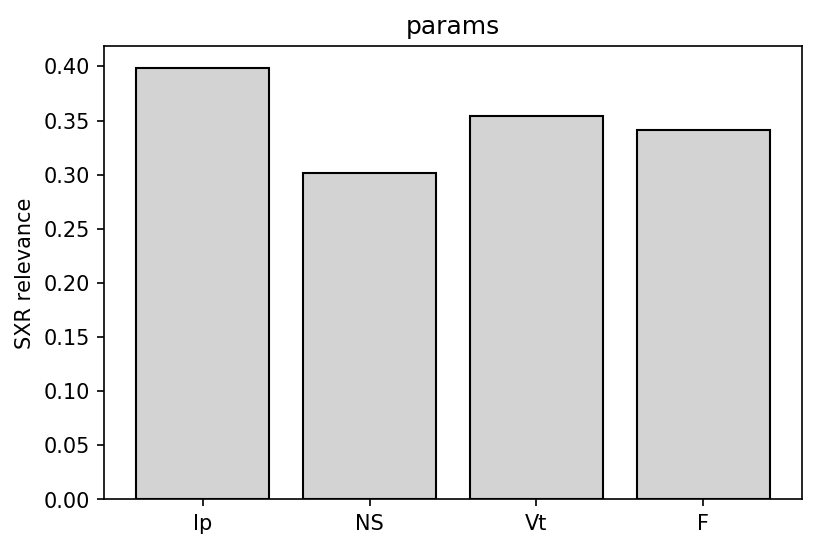

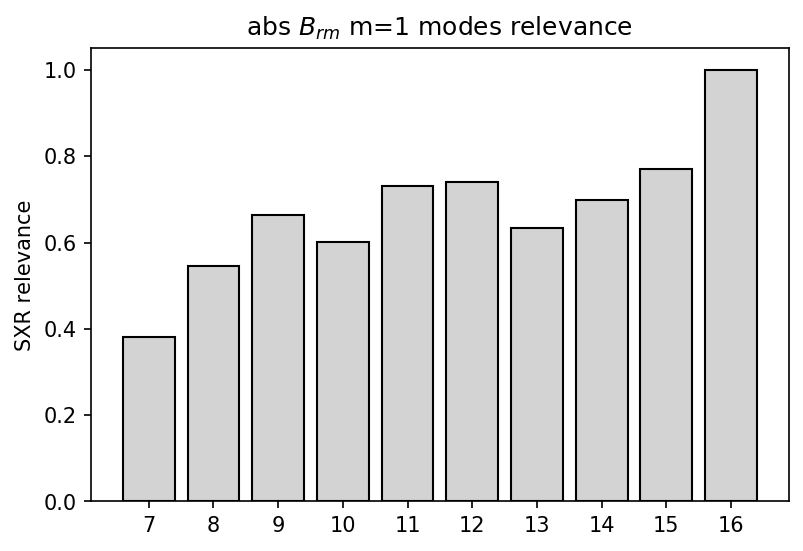

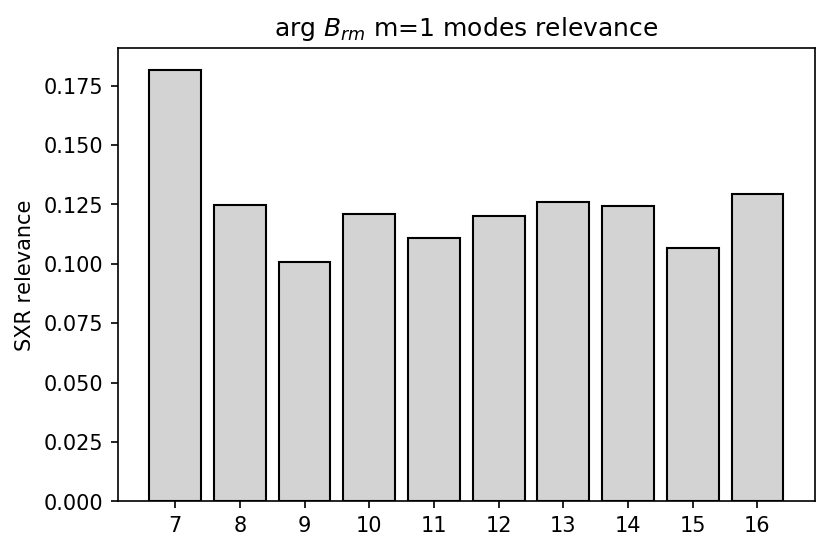

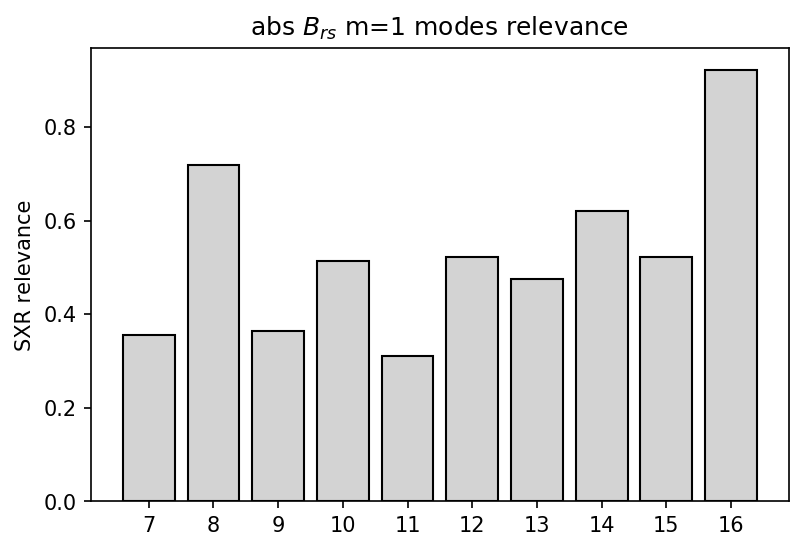

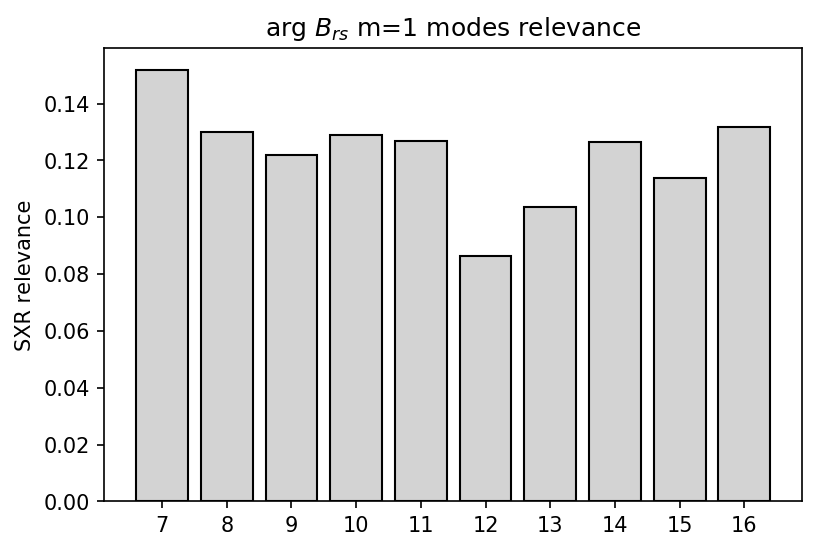

In [11]:
index = qsh[0].n
w = gen.layers[1].weights
%matplotlib inline

def plot_bar_x(index, w, title, w2=None):
    # this is for plotting purpose
    fig = plt.figure(title)
    fig.set_dpi(150)
    plt.bar(index, w, color='lightgrey', edgecolor='black')    
    plt.ylabel('SXR relevance', fontsize=10)
    plt.xticks(index, fontsize=10)
    plt.title(title)
    plt.show()

p,abs_Brm,arg_Brm,abs_Brs,arg_Brs = w[0][0:4],w[0][4:14], w[0][14:24], w[0][24:34], w[0][34:44]
plot_bar_x(['Ip','NS','Vt','F'], p, 'params')
plot_bar_x(index, abs_Brm, 'abs $B_{rm}$ m=1 modes relevance')
plot_bar_x(index, arg_Brm, 'arg $B_{rm}$ m=1 modes relevance')
plot_bar_x(index, abs_Brs, 'abs $B_{rs}$ m=1 modes relevance')
plot_bar_x(index, arg_Brs, 'arg $B_{rs}$ m=1 modes relevance')


In [12]:
pos = 0

265


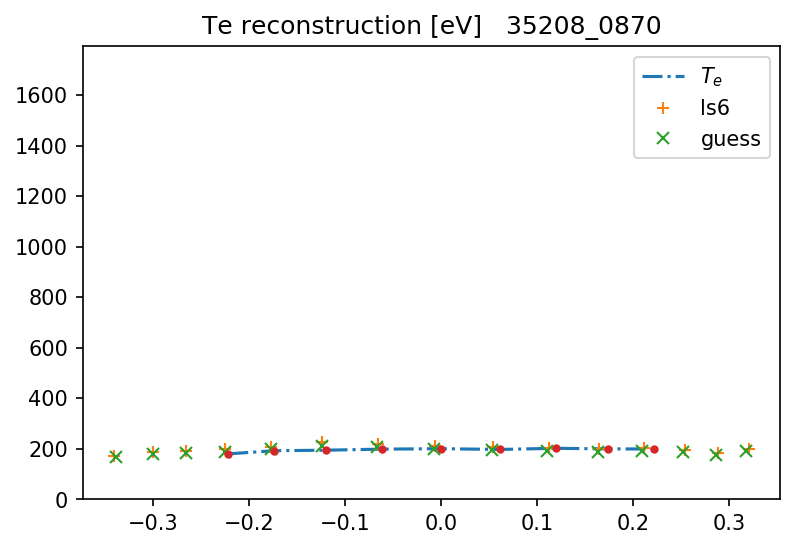

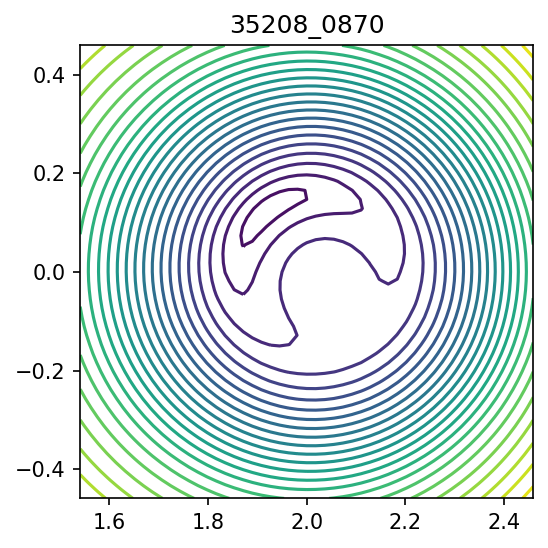

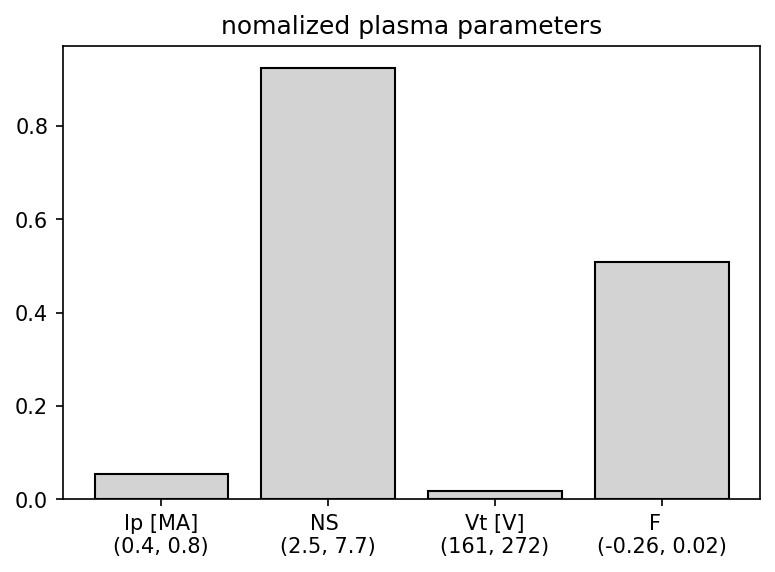

In [34]:
print(pos)


def un(x, min=0., max=2242.511):
    return min + x*(max-min)

def unx(x, min=-0.373, max=0.353):
    return min + x*(max-min)

def plot_tf(xy, name=None, h='.'):
    fig = plt.figure('plot')    
    fig.set_dpi(150)
    ax = plt.gca()    
    ax.set_ylim(0.,un(0.8))
    xy = tf.reshape(xy, [-1])
    x,y = tf.split(xy, num_or_size_splits=2, axis=0)
    plt.plot(unx(x),un(y),h, label=name)
    ax.legend()

def plot(x,y, name=None, h='.'):  
    fig = plt.figure('plot')    
    fig.set_dpi(150)
    ax = plt.gca()    
    ax.set_ylim(0.,un(0.8))
    plt.plot(unx(x),un(y), h, label=name)
    #ax.legend()
    
def plot_bar_x(index, w, title, w2=None):
    # this is for plotting purpose
    fig = plt.figure(title)
    plt.clf()
    fig.set_dpi(150)
    plt.bar(index, w, color='lightgrey', edgecolor='black')    
    # plt.ylabel('plasma parameters', fontsize=10)
    plt.xticks(index, fontsize=10)
    plt.title(title)
    return fig
    
def plot_te(pos):    
    d_pos = [x for x in ds.skip(pos).batch(1).take(1)][0]
    path = '/home/andrea/Documents/phd/Thesis/img/STEP12/STEP12_7'
    p  = d_pos[0]
    xy = d_pos[1]

    fig = plt.figure('plot')
    plt.clf()
    # plt.text(0.05,0.7, '$I_p = %.2f$'%qsh[pos]['Ip'] )
    ax = plt.gca()
    ax.set_title( 'Te reconstruction [eV]   '+qsh[pos].label.decode("utf-8") )

    XY_vae = vae(xy, training=False)
    ls = gen(d_pos[0], training=False)
    XY = vae.decode(ls, training=False)
    # XY = tf.sigmoid(XY)
    plot_tf(xy, '$T_e$','-.')
    plot_tf(XY_vae, 'ls6','+')
    plot_tf(XY, 'guess','x')
    plot(qsh[pos]['prel'],qsh[pos]['te'], '$T_c$')

    fig2 = plt.figure('contour')
    plt.clf()
    ax2  = plt.gca()
    fig2.set_dpi(150)
    qsh[pos].plot_countour(ax=ax2)
    #ax2.set_title('SHeq')
    fig2.savefig( path+'/Contour_'+str(pos)+'.png')

    fig3 = plot_bar_x(['Ip [MA]\n(0.4, 0.8)',
                       'NS \n(2.5, 7.7)',
                       'Vt [V]\n(161, 272)',
                       'F  \n(-0.26, 0.02)'], qsh[pos]['Ip~NS~VT~F'], 'nomalized plasma parameters')
    fig3.savefig( path+'/Params_'+str(pos)+'.png')

    fig = plt.figure('plot')
    fig.savefig( path+'/Te_rec_'+str(pos)+'.png')

# for pos in range(250):
#     plot_te(pos)
plot_te(pos)
pos = pos+1

In [ ]:
q = [q for q in ds.batch(2).take(1)][0]
q

In [ ]:
loss = {
    'mse' : [],
    'sum_e' : [],
#    'sum_ve': [],
    'max' : [],
    'min' : [],
    'Ip' : [],
    'NS' : [],
    'Vt' : [],
    'F'  : [],
}
fig = plt.figure()

def un(x, min, max):
    return min + x*(max-min)

for i,d_pos in enumerate(ds.batch(300).take(10)):
    p  = d_pos[0]
    xy = d_pos[1]
    XY_vae = vae(xy, training=False)
    ls = gen(d_pos[0], training=False)
    XY = vae.decode(ls, training=False)
    
    prel = tf.split(p, split_)
    
    mse = tf.losses.mse(XY_vae,XY)
    sum_e = tf.reduce_sum( (XY_vae-XY), axis=1) / 15
    max_e = tf.reduce_max( XY_vae-XY, axis=1) 
    min_e = tf.reduce_min( XY_vae-XY, axis=1) 
    # plot_tf(XY_vae, 'ls6','+')
    # plot_tf(XY, 'guess','x')
    for i in range(300):
        loss['mse'].append( un(mse[i].numpy(),0.,2242.511) )
        loss['sum_e'].append( un(sum_e[i].numpy(),0.,2242.511)  )
        loss['max'].append( un(max_e[i].numpy()-min_e[i].numpy(),0.,2242.511)  )
        loss['min'].append( un(min_e[i].numpy()-max_e[i].numpy(),0.,2242.511)  )
        loss['Ip'].append( un(p[i][0].numpy(),0.41,0.79) )
        loss['NS'].append( un(p[i][1].numpy(),2.55,7.69) )
        loss['Vt'].append( un(p[i][2].numpy(),161.15, 272.39) ) 
        loss['F'].append(p[i][3].numpy())
    

In [ ]:
import seaborn as sns
from scipy import stats

#x = np.clip( np.array(loss['sum_e']), a_min=-200., a_max=200. )
lim = 200.
lim_f = 200.
x = np.array(loss['sum_e'])
X_in  = x[ (x > -lim_f) & (x < lim_f) ]
X_out = x[ (x < -lim_f) | (x > lim_f) ]

ax = sns.distplot( x, kde=False ,norm_hist=True, hist_kws={"range": [-lim,lim], "histtype": "step", "linewidth": 2, "color": "k"} );

xx = np.arange(-lim,lim, 0.1)
mu,std = stats.norm.fit(X_in)
yy = stats.norm.pdf(xx,mu,std)
ax.plot(xx,yy,'--k', label='norm')

# mu,std = stats.logistic.fit(x)
# yy = stats.logistic.pdf(xx,mu,std)
# ax.plot(xx,yy,'-.r', label='N_2')


fig = plt.gcf()
fig.set_dpi(150)
plt.xlim(-190,190)
#plt.legend()

ax.set_title('mean SRX reconstruction error')

plt.text(100,0.006,'$\sigma = %.2f$\nKurt $= %.2f$'%(x.std(),stats.kurtosis(x)))

print('norm',stats.norm.fit(x))
print('kurt',stats.kurtosis(x))
print('logistic',stats.logistic.fit(x))

In [ ]:
import seaborn as sns
from scipy import stats

#x = np.clip( np.array(loss['sum_e']), a_min=-200., a_max=200. )
lim = 200.
x = loss['max']
# x = x[ x < lim ]
# x = x[ x > -lim ]

ax = sns.distplot( x, kde=False, norm_hist=True, hist_kws={"range": [-lim,lim]} );

xx = np.arange(-lim,lim, 0.1)
mu,std = stats.norm.fit(x)
yy = stats.norm.pdf(xx,mu,std)
ax.plot(xx,yy,'--k', label='norm')

mu,std = stats.logistic.fit(x)
yy = stats.logistic.pdf(xx,mu,std)
ax.plot(xx,yy,'-.r', label='logisitc')


fig = plt.gcf()
fig.set_dpi(150)
# plt.xlim(-190,190)
plt.legend()

ax.set_title('max SRX error distribution')
print('norm',stats.norm.fit(x))
print('logistic',stats.logistic.fit(x))

In [ ]:
print(len(loss['mse']))
fig = plt.figure('params vs mse')
fig.set_dpi(150)
ax = plt.gca()
ax.set_title('Ip [MA] vs mse on reconstructed SXR')
# plt.yscale('log')
# plt.plot(loss['Ip'],loss['mse'],'+')
plt.plot(loss['Ip'],np.log(loss['max']),'x')
# plt.plot(loss['NS'],loss['mse'],'x')
# plt.plot(loss['Vt'],loss['mse'],'.')
# plt.plot(loss['F'],loss['mse'],'.')

fig = plt.figure('Ip hist')
fig.set_dpi(150)
ax = plt.gca()
ax.set_title('Ip [MA] vs mse on reconstructed SXR')
plt.hist2d(loss['Ip'], np.log(loss['max']), (50, 50), cmap=plt.cm.jet)
# plt.hist2d(loss['Ip'], loss['sum_e'], (50, 50), cmap=plt.cm.jet)
# plt.colorbar()

In [ ]:
print(len(loss['mse']))
fig = plt.figure('params vs mse')
fig.set_dpi(150)
ax = plt.gca()
ax.set_title('NS vs mse on reconstructed SXR')
plt.yscale('log')
plt.plot(loss['NS'],loss['mse'],'+')


fig = plt.figure('NS hist')
ax = plt.gca()
ax.set_title('NS vs log(mse) on reconstructed SXR')
fig.set_dpi(150)
plt.hist2d(loss['NS'], np.log(loss['mse']), (50, 50), cmap=plt.cm.jet)
# plt.colorbar()
